In [67]:
import wandb
import torch
api = wandb.Api()

# Specify your project and entity
project = "Heat_9_25"
entity = "kaist_yegonkim"

# Get all runs from the project
runs = api.runs(f"{entity}/{project}")

# Filter runs based on configurations and collect metrics
filtered_metrics = []
for run in runs:
    
    # Example: Filter runs where batch_size is 32 and learning_rate is 0.001
    if run.config.get('comment') is None and run.config.get('mean_field') == False:
        # Collect specific metrics, e.g., 'accuracy' and 'loss'
        metrics = {
            'seed': run.config.get('seed'),
            'initial_selection_method': run.config.get('initial_selection_method'),
            'post_selection_method': run.config.get('post_selection_method'),
        }
        history = run.scan_history()
        run_metrics = []
        for step in history:
            step_metrics = {
                'step': step.get('_step'),
                'datasize': step.get('datasize'),
                'rmse': step.get('test/L2'),
                'nrmse': step.get('test/Relative_L2'),
                'mae': step.get('test/MAE'),
                '99': step.get('test/99_L2'),
                '95': step.get('test/95_L2'),
                '50': step.get('test/50_L2'),
            }
            if step_metrics['rmse'] is not None:
                run_metrics.append(step_metrics)
        if len(run_metrics) == 0:
            continue
        run_metrics = {k: [run_metrics[i][k] for i in range(len(run_metrics))] for k in run_metrics[0]}
        run_metrics = {k: torch.tensor(v) for k, v in run_metrics.items()}
        
        metrics['metrics'] = run_metrics

        filtered_metrics.append(metrics)

# filtered_metrics:
# [{'seed': 0, 'initial_selection_method': 'random', 'post_selection_method': 'random', 'metrics': {'step': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'datasize': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'rmse': [

In [68]:
grouped_metrics = {}
for metrics in filtered_metrics:
    key = (metrics['initial_selection_method'], metrics['post_selection_method'])
    if key not in grouped_metrics:
        grouped_metrics[key] = []
    grouped_metrics[key].append(metrics['metrics'])
for key in grouped_metrics:
    grouped_metrics[key] = {k: torch.stack([metrics[k] for metrics in grouped_metrics[key]]) for k in grouped_metrics[key][0] if k != 'step'}

In [69]:
# convert keys as follows
conversion_0 = {'random': 'Random', 'variance': 'QbC', 'lcmd_hidden': 'LCMD', 'stochastic_1.0': 'SBAL'}
conversion_1 = {'all': '', 'flexible_max': '+FlexAL'}

grouped_metrics = {f"{conversion_0[k[0]]}{conversion_1[k[1]]}": v for k, v in grouped_metrics.items()}

In [70]:
average_metrics = {key: {k: v.float().mean(dim=0) for k, v in grouped_metrics[key].items()} for key in grouped_metrics}
std_metrics = {key: {k: v.float().std(dim=0) for k, v in grouped_metrics[key].items()} for key in grouped_metrics}

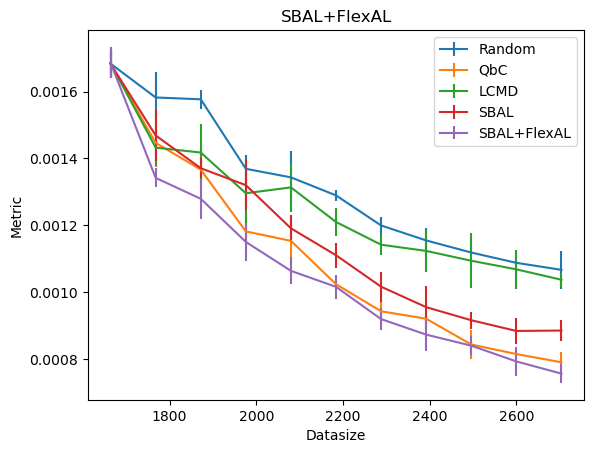

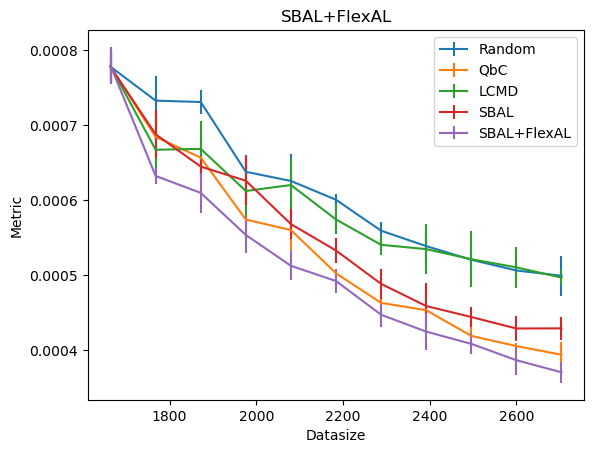

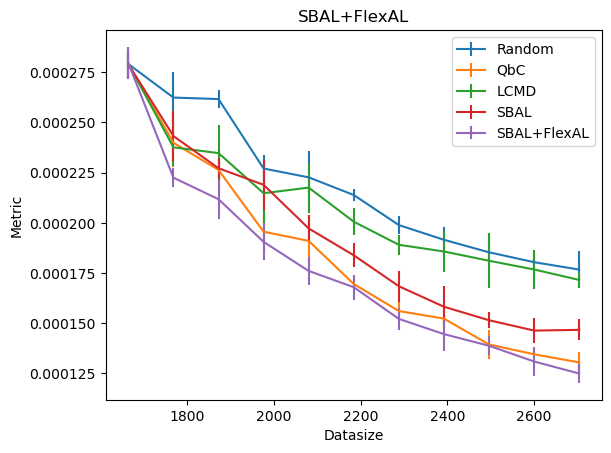

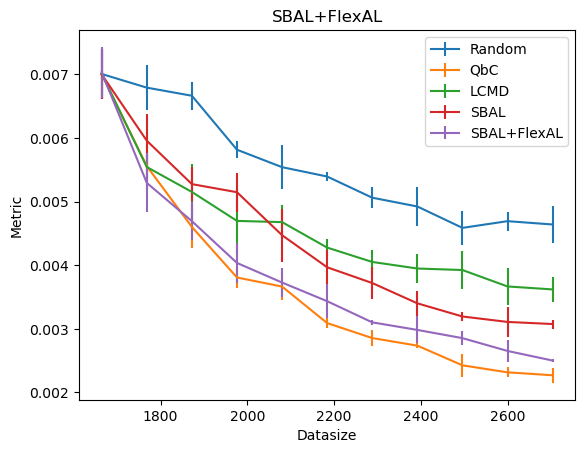

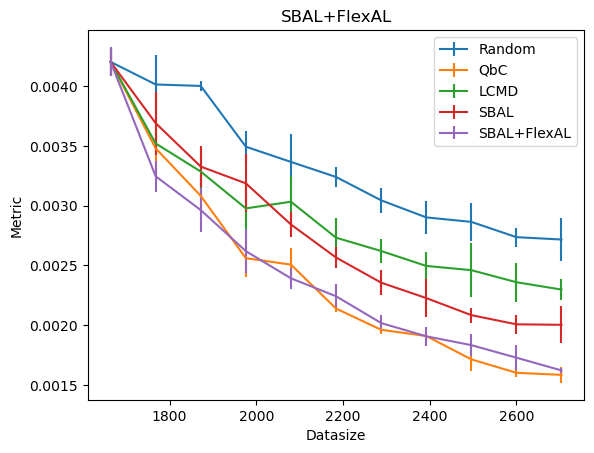

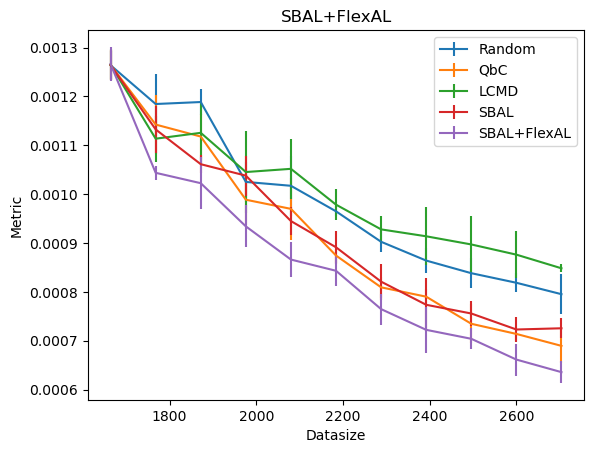

In [72]:
from matplotlib import pyplot as plt

metric_names = {'rmse': 'RMSE', 'nrmse': 'NRMSE', 'mae': 'MAE', '99': '99% quantile RMSE', '95': '95% quantile RMSE', '50': '50% quantile RMSE'}

for metric in metric_names:
    plt.figure()
    for key in average_metrics:
        plt.errorbar(average_metrics[key]['datasize'], average_metrics[key][metric], yerr=std_metrics[key][metric], label=key)
    plt.xlabel('Datasize')
    plt.ylabel('Metric')
    plt.legend()
    plt.title(metric)
    plt.show()

# plt.figure()
# for key in average_metrics:
#     plt.errorbar(average_metrics[key]['datasize'], average_metrics[key]['rmse'], yerr=std_metrics[key]['rmse'], label=key)
# plt.xlabel('Datasize')
# plt.ylabel('RMSE')
# plt.legend()
# plt.show()
